In [1]:
!hostname

login-q-1


In [2]:
import sys
import os

# Add the root directory to the system path
root_dir = os.path.abspath("..")  # Assuming the notebook is one level deep in the 'notebooks' directory
if root_dir not in sys.path:
    sys.path.append(root_dir)

In [3]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, QED
from rdkit.Chem import Draw
from rdkit.Chem.rdchem import MolSanitizeException
import random

In [4]:
enamine_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_building_blocks.csv")
rxn_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_set_processed.txt", delimiter="|")

# Random search baseline

In [5]:
enamine_df.head()

SMILES
0  CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...
1  CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c...
2  CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...
3  CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...
4  CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...

# Random Search Result EXploration

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [62]:
results = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/raw_data/random_molsearch_results.csv")

In [63]:
results.head()

step                      reactant                 template  \
0     0                 Cc1nnnn1CCCCl                      NaN   
1     1                 Cc1nnnn1CCCCl         Williamson_ether   
2     2      Cc1nnnn1CCCOC1(CCCN)CCC1  Quinazolinone_formation   
3     0  O=C(O)C1NCCc2c1[nH]c1ccccc21                      NaN   
4     1  O=C(O)C1NCCc2c1[nH]c1ccccc21        FGI_Acyl_chloride   

                                      product       qed     second_reactant  
0                               Cc1nnnn1CCCCl  0.608998                 NaN  
1                    Cc1nnnn1CCCOC1(CCCN)CCC1  0.700502       NCCCC1(O)CCC1  
2  Cc1nnnn1CCCOC1(CCCn2cnc3c(F)cccc3c2=O)CCC1  0.513306  Nc1c(F)cccc1C(=O)O  
3                O=C(O)C1NCCc2c1[nH]c1ccccc21  0.675425                 NaN  
4               O=C(Cl)C1NCCc2c1[nH]c1ccccc21  0.742808                 NaN

In [64]:
results.describe()

step           qed
count  14269.000000  14269.000000
mean       1.497862      0.524127
std        1.439928      0.246830
min        0.000000      0.014252
25%        0.000000      0.315891
50%        1.000000      0.582752
75%        2.000000      0.724659
max        5.000000      0.944888

In [65]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14269 entries, 0 to 14268
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             14269 non-null  int64  
 1   reactant         14269 non-null  object 
 2   template         10000 non-null  object 
 3   product          14269 non-null  object 
 4   qed              14269 non-null  float64
 5   second_reactant  7896 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 669.0+ KB


In [127]:
# Identify unique products that are not in the list of reactants
reactants_set = set(results['reactant'].unique())
unique_products = [product for product in results['product'].unique() if product not in reactants_set]
    
# Calculate QED for each unique product
unique_products_qed = []
for product in unique_products:
    mol = Chem.MolFromSmiles(product)
    if mol:
        qed = QED.qed(mol)
        unique_products_qed.append((product, qed))

# Create DataFrame and sort by QED
unique_products_df = pd.DataFrame(unique_products_qed, columns=['Product', 'QED']).sort_values(by='QED', ascending=False)

# Display unique products
print("Unique Products and Their QED Values:")
unique_products_df

Unique Products and Their QED Values:


Product       QED
707                  O=c1c2cccc(F)c2nc(C2CSCN2)n1CC1CC1  0.944888
2038               CC(C)(C)c1cnc(Oc2ccc(F)cc2C(N)=O)cn1  0.942005
140                NC(=O)c1ccc(Cn2c(C3CC3)cc3c2CCCC3)o1  0.937830
2783            FC(F)(F)c1ccc(C(c2nn[nH]n2)N2CCOCC2)cc1  0.932917
1700        CCN(C)C(=O)c1ccc(CN2CC(=O)Nc3cc(C)cnc32)cc1  0.929834
...                                                 ...       ...
3172  CCC(C)C(NCc1c[nH]c2nccc(Cl)c12)C(=O)NC[C@H](CC...  0.017361
3346  CCOC(=O)C12CN(c3ccccc3)CCC1(c1c(-c3ccc(C(C)C)c...  0.016553
2784  CCCCCNCc1cccc(OC(=O)c2[nH]c3ccccc3c2C23CCN(c4c...  0.015734
3237  CCCn1c(C2(C(c3[nH]c4c([N+](=O)[O-])cc(S(=O)(=O...  0.015153
2881  CCN(CC)S(=O)(=O)c1cc([N+](=O)[O-])c2[nH]c(C3Cc...  0.014252

[3935 rows x 2 columns]

In [81]:
# Set up seaborn style without grid lines
sns.set(style="white", palette="muted", color_codes=True)

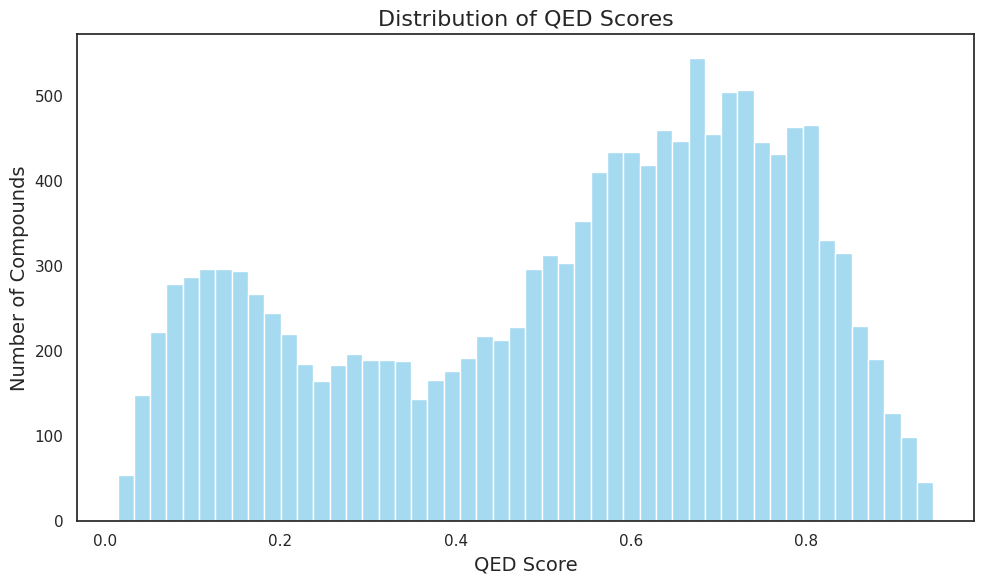

In [94]:
# Plot QED scores
plt.figure(figsize=(10, 6))
sns.histplot(results['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores', fontsize=16)
plt.xlabel('QED Score', fontsize=14)
plt.ylabel('Number of Compounds', fontsize=14)
plt.tight_layout()
plt.show()

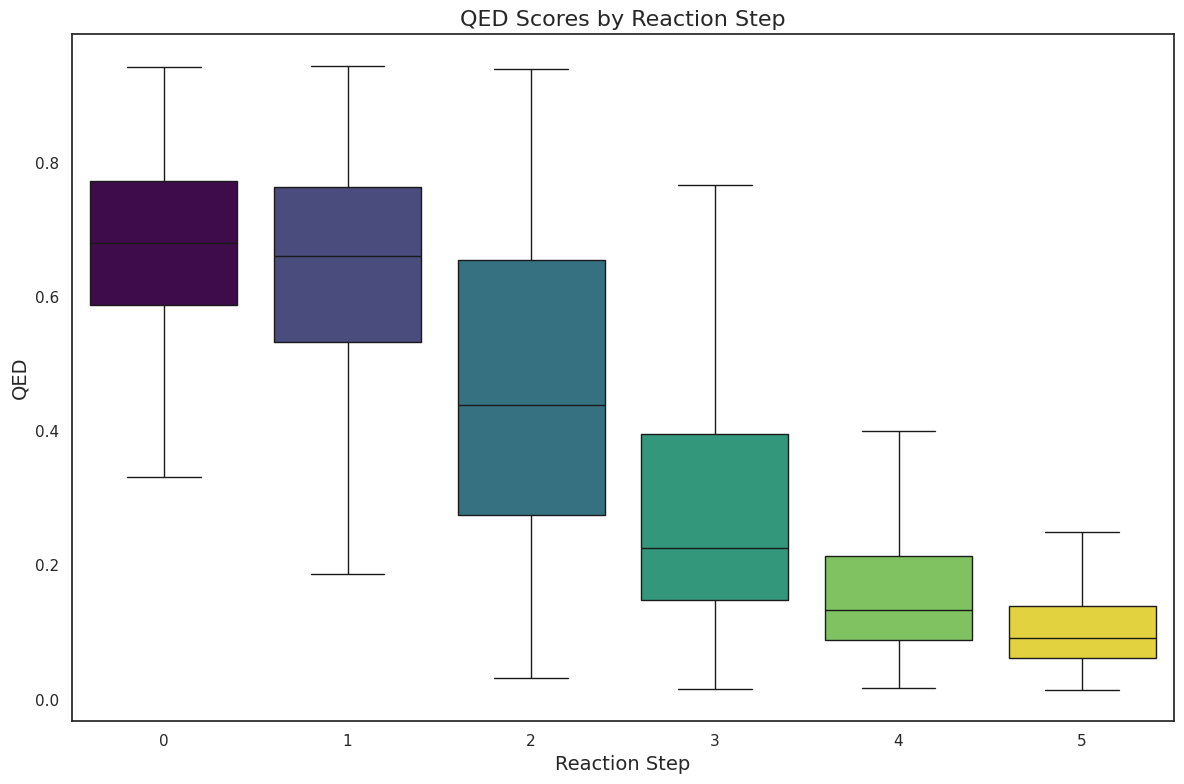

In [90]:
# Box plot for QED scores by reaction step with customized settings to avoid FutureWarning
plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='qed', data=results, hue='step', palette="viridis", showfliers=False, dodge=False)
plt.legend([], [], frameon=False)  # Remove legend
plt.title('QED Scores by Reaction Step', fontsize=16)
plt.xlabel('Reaction Step', fontsize=14)
plt.ylabel('QED', fontsize=14)
plt.tight_layout()
plt.show()


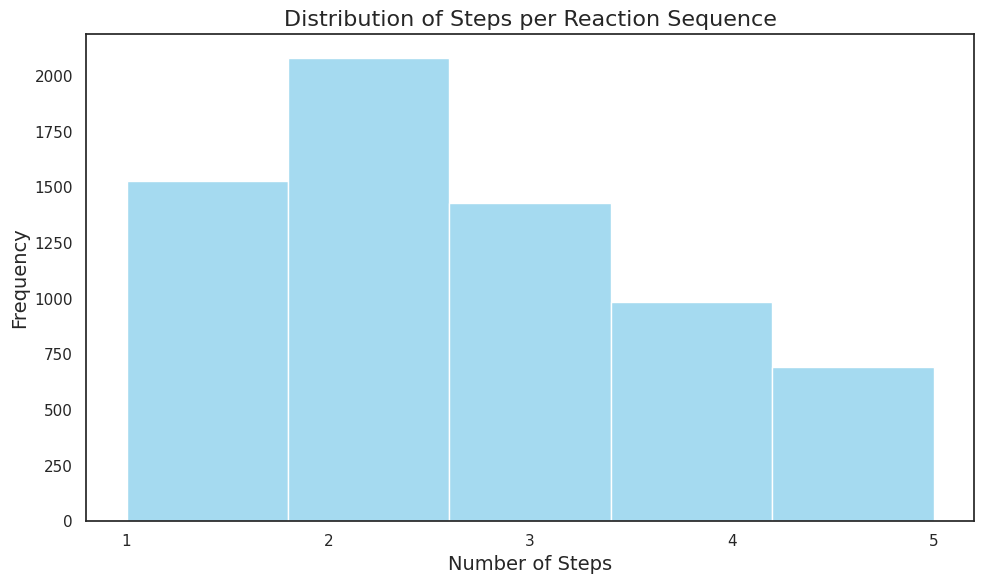

In [98]:
# Plot steps per reaction sequence
steps_per_sequence = results.groupby('reactant')['step'].max()

plt.figure(figsize=(10, 6))
sns.histplot(steps_per_sequence, bins=5, kde=False, color='skyblue')
plt.title('Distribution of Steps per Reaction Sequence', fontsize=16)
plt.xlabel('Number of Steps', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(1, 5 + 1))  # Set x-ticks to whole numbers
plt.tight_layout()
plt.show()

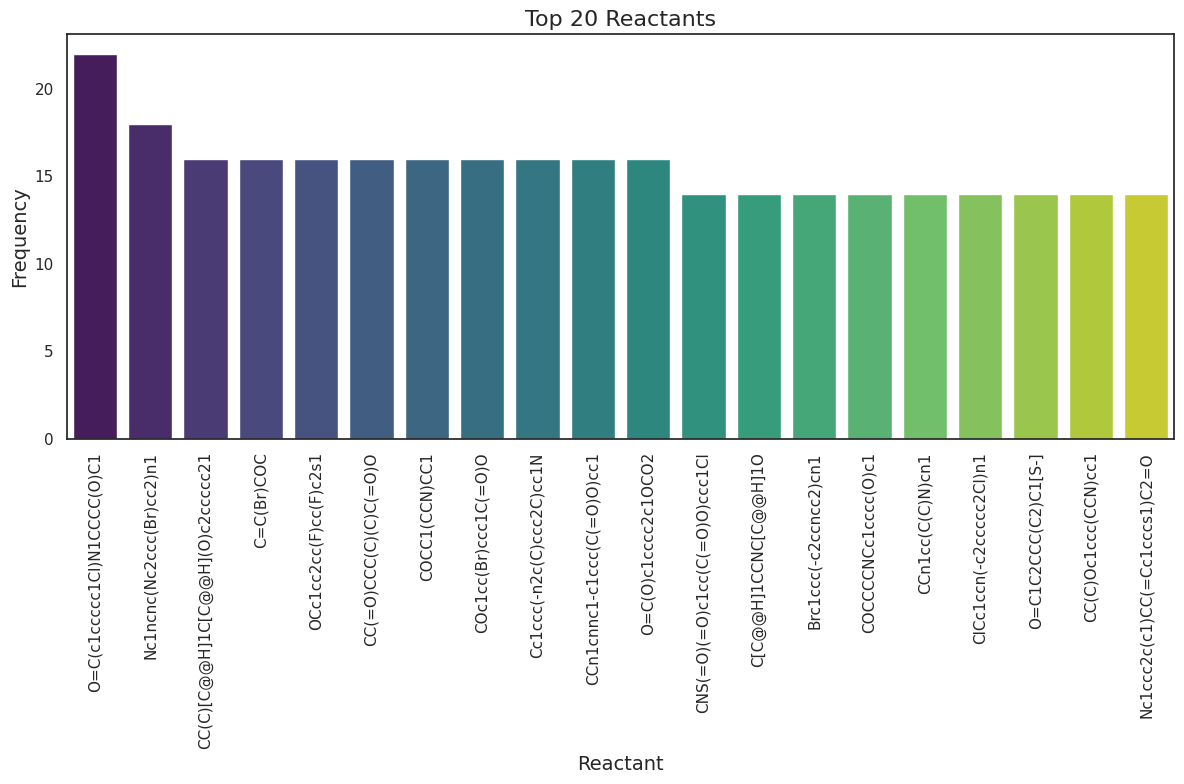

In [100]:
# Plot top 20 reactants
reactants = results['reactant'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=reactants.head(20).index, hue=reactants.head(20).index, y=reactants.head(20).values, palette='viridis')
plt.title('Top 20 Reactants', fontsize=16)
plt.xlabel('Reactant', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

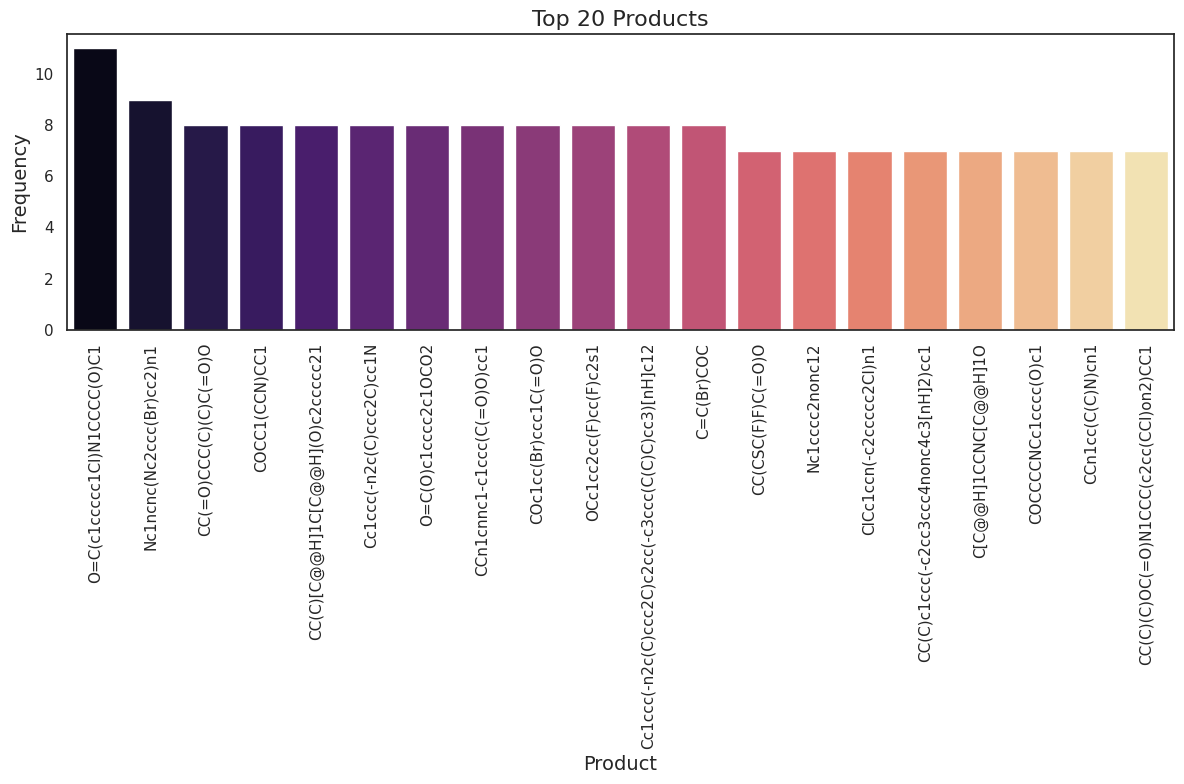

In [102]:
# Plot top 20 products
products = results['product'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=products.head(20).index, hue=products.head(20).index, y=products.head(20).values, palette='magma')
plt.title('Top 20 Products', fontsize=16)
plt.xlabel('Product', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

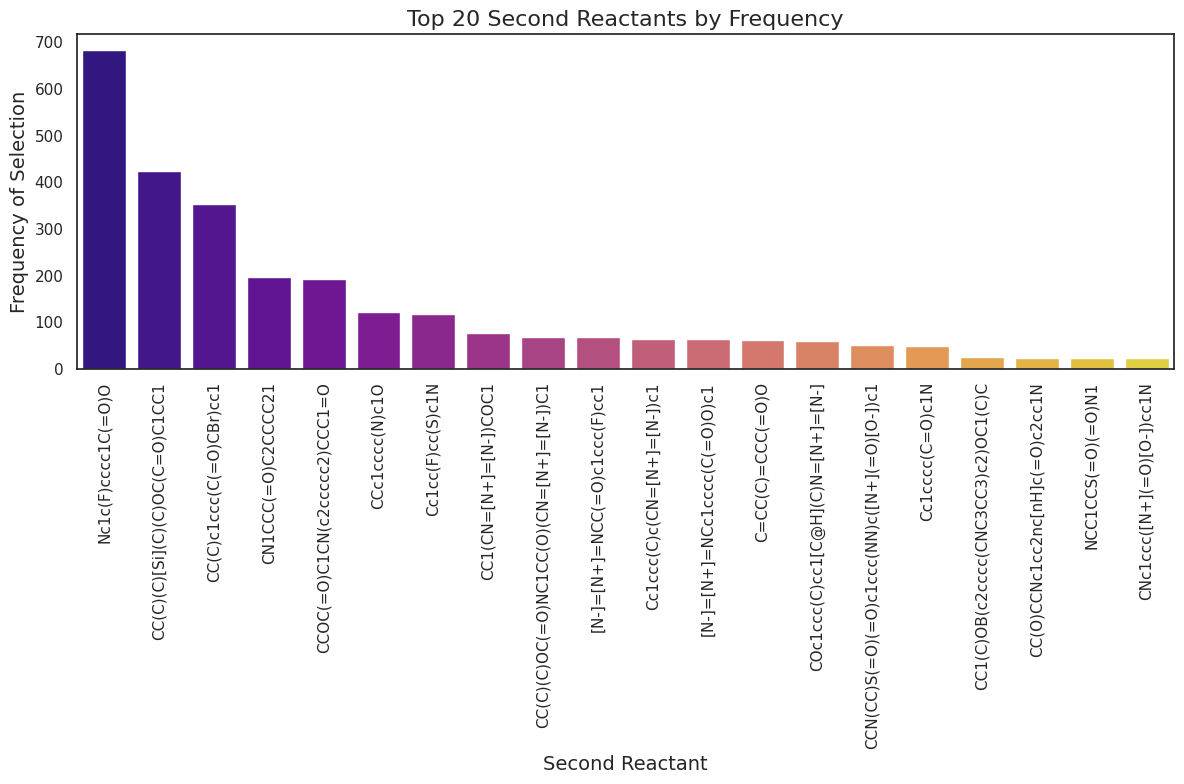

In [103]:
# Plot top 20 second reactants by frequency of selection in bimolecular reactions
second_reactants = results['second_reactant'].dropna().value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=second_reactants.head(20).index, hue=second_reactants.head(20).index, y=second_reactants.head(20).values, palette='plasma')
plt.title('Top 20 Second Reactants by Frequency', fontsize=16)
plt.xlabel('Second Reactant', fontsize=14)
plt.ylabel('Frequency of Selection', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

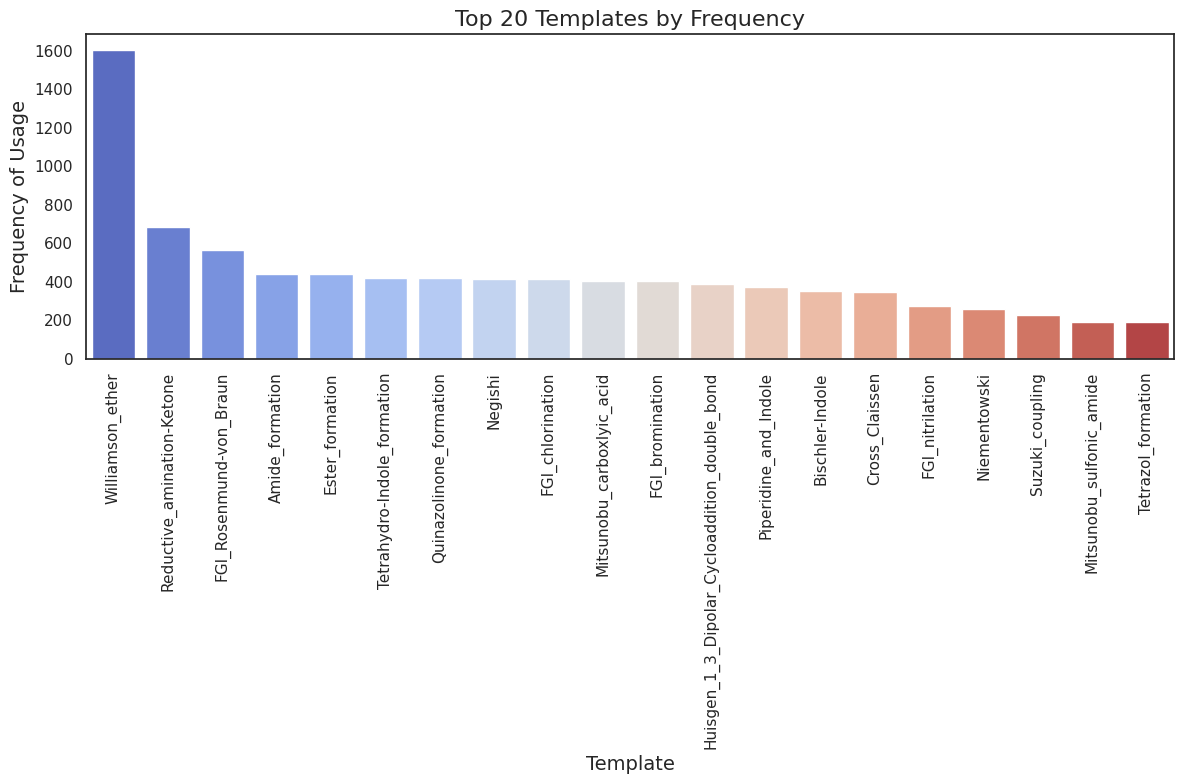

In [105]:
# Plot template usage frequency
templates = results['template'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=templates.head(20).index, hue=templates.head(20).index, y=templates.head(20).values, palette='coolwarm')
plt.title('Top 20 Templates by Frequency', fontsize=16)
plt.xlabel('Template', fontsize=14)
plt.ylabel('Frequency of Usage', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [108]:
# Identify the product with the highest QED score
max_qed_row = results.loc[results['qed'].idxmax()]
highest_qed_product = max_qed_row['product']
highest_qed_sequence = results[results['product'] == highest_qed_product].drop_duplicates()

In [109]:
highest_qed_sequence

step             reactant      template  \
2411     1  O=C(NCC1CC1)C1CSCN1  Niementowski   

                                 product       qed     second_reactant  
2411  O=c1c2cccc(F)c2nc(C2CSCN2)n1CC1CC1  0.944888  Nc1c(F)cccc1C(=O)O

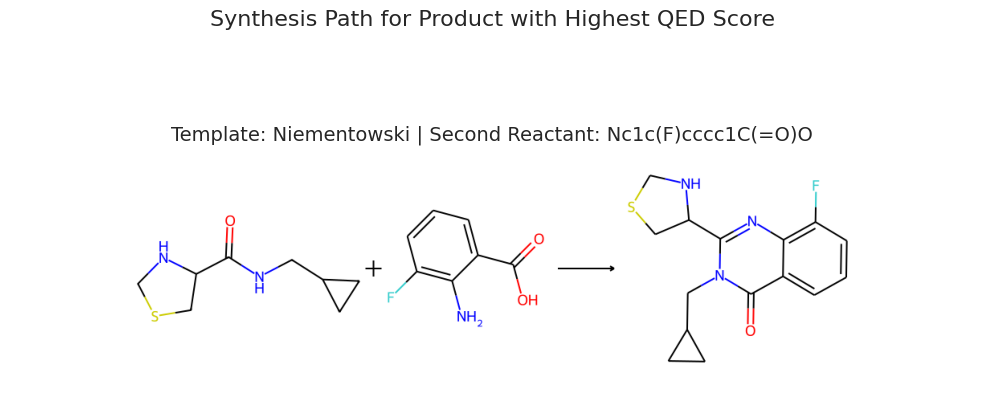

In [118]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import ReactionToImage
from rdkit.Chem import AllChem

# Visualize the synthesis path using RDKit
synthesis_path = []
for _, row in highest_qed_sequence.iterrows():
    synthesis_path.append((row['reactant'], row['product'], row['template'], row['second_reactant'] if 'second_reactant' in row else None))

# Generate reaction images
reactions = []
for reactant, product, template, second_reactant in synthesis_path:
    if second_reactant and pd.notna(second_reactant):
        reactants = [Chem.MolFromSmiles(reactant), Chem.MolFromSmiles(second_reactant)]
    else:
        reactants = [Chem.MolFromSmiles(reactant)]
    products = [Chem.MolFromSmiles(product)]
    rxn = AllChem.ChemicalReaction()
    for r in reactants:
        rxn.AddReactantTemplate(r)
    for p in products:
        rxn.AddProductTemplate(p)
    reactions.append(rxn)

# Draw the reactions
reaction_images = [ReactionToImage(rxn, subImgSize=(300, 300)) for rxn in reactions]
    
# Display the reaction images
fig, axes = plt.subplots(len(reaction_images), 1, figsize=(10, 5 * len(reaction_images)))
if len(reaction_images) == 1:
    axes = [axes]
for ax, img, (reactant, product, template, second_reactant) in zip(axes, reaction_images, synthesis_path):
    ax.imshow(img)
    ax.axis('off')
    title = f"Template: {template}"
    if second_reactant and pd.notna(second_reactant):
        title += f" | Second Reactant: {second_reactant}"
    ax.set_title(title, fontsize=14)

plt.suptitle('Synthesis Path for Product with Highest QED Score', fontsize=16)
plt.tight_layout()
plt.show()


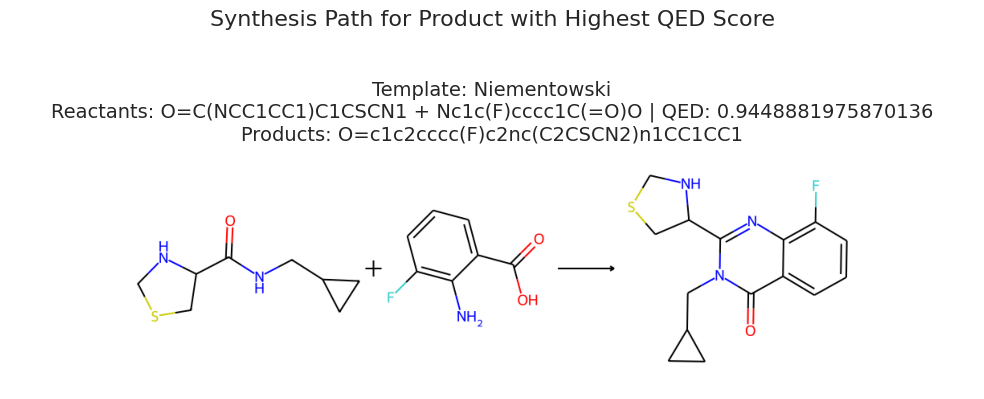

In [119]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import ReactionToImage
from rdkit.Chem import AllChem

# Visualize the synthesis path using RDKit
synthesis_path = []
for _, row in highest_qed_sequence.iterrows():
    synthesis_path.append((row['reactant'], row['product'], row['template'], row['second_reactant'], row['qed']))

# Generate reaction images
reactions = []
for reactant, product, template, second_reactant, qed in synthesis_path:
    if second_reactant and pd.notna(second_reactant):
        reactants = [Chem.MolFromSmiles(reactant), Chem.MolFromSmiles(second_reactant)]
    else:
        reactants = [Chem.MolFromSmiles(reactant)]
    products = [Chem.MolFromSmiles(product)]
    rxn = AllChem.ChemicalReaction()
    for r in reactants:
        rxn.AddReactantTemplate(r)
    for p in products:
        rxn.AddProductTemplate(p)
    reactions.append((rxn, reactants, products, template, qed))

# Draw the reactions
reaction_images = []
for rxn, reactants, products, template, qed in reactions:
    img = ReactionToImage(rxn, subImgSize=(300, 300))
    reaction_images.append((img, reactants, products, template, qed))
    
# Display the reaction images
fig, axes = plt.subplots(len(reaction_images), 1, figsize=(10, 5 * len(reaction_images)))
if len(reaction_images) == 1:
    axes = [axes]
for ax, (img, reactants, products, template, qed) in zip(axes, reaction_images):
    ax.imshow(img)
    ax.axis('off')
    reactants_str = ' + '.join([Chem.MolToSmiles(mol) for mol in reactants])
    products_str = ' + '.join([Chem.MolToSmiles(mol) for mol in products])
    title = f"Template: {template}\nReactants: {reactants_str} | QED: {qed}\nProducts: {products_str}"
    ax.set_title(title, fontsize=14)

plt.suptitle('Synthesis Path for Product with Highest QED Score', fontsize=16)
plt.tight_layout()
plt.show()


# Modified RandomMolSearch

# RandomMolSearch
1. 400000 max reaction steps, and 800000 max attempts
2. run for 5hrs, completed 65000 reaction steps


In [4]:
import sys
import os

# Add the root directory to the system path
root_dir = os.path.abspath("..")  # Assuming the notebook is one level deep in the 'notebooks' directory
if root_dir not in sys.path:
    sys.path.append(root_dir)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.chem.synthesis_path import print_path, draw_path
from src.chem.chem_utils import get_compound_name

# Set up seaborn style without grid lines
#sns.set(style="white", palette="muted", color_codes=True)

In [5]:
rxn_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_set_processed.txt", delimiter="|")
rxn_df

Reaction  \
0              Bischler-Napieralski   
1                       Pictet-Gams   
2   Pictet-Spengler-6-membered-ring   
3   Pictet-Spengler-5-membered-ring   
4                   Bischler-Indole   
..                              ...   
59            FGI_sulfonyl_chloride   
60            FGA_alpha_bromination   
61           FGA_alpha_chlorination   
62          FGI_Rosenmund-von_Braun   
63                  FGI_nitrilation   

                                               Smarts          Type  
0   [$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...  unimolecular  
1   [$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...  unimolecular  
2   [NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...   bimolecular  
3   [NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...   bimolecular  
4   [NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...   bimolecular  
..                                                ...           ...  
59  [OH,O-:3][S$(S([CX4])):2](=[O:4])=[O:5]>>[Cl:6...  unimolecular  
60  [OH+0,O-:5]-[C:3](=[O:4])-[C$([CH]([CX4])),C$(...  unimolecular  
61  [OH+0,O-:5]-[C:3](=[O:4])-[C$([CH]([CX4])),C$(...  unimolecular  
62  [Cl,I,Br:7][c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[...  unimolecular  
63  [OH,NH2,NH3+:3]-[CH2:2]-[C$(C([CX4,c])([CX4,c]...  unimolecular  

[64 rows x 3 columns]

In [6]:
rxn_df.describe()

Reaction  \
count                     64   
unique                    64   
top     Bischler-Napieralski   
freq                       1   

                                                   Smarts         Type  
count                                                  64           64  
unique                                                 64            2  
top     [$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...  bimolecular  
freq                                                    1           49

In [7]:
def has_agents(rxn_smarts):
    # Split the reaction SMARTS string by '>'
    parts = rxn_smarts.split('>')
    # Check if there are exactly three parts: reactants, agents, and products
    if len(parts) == 3:
        # Check if the agents part is not empty
        agents = parts[1].strip()
        return len(agents) > 0
    else:
        # If there are not exactly three parts, there are no agents
        return False

In [8]:
rxn_with_agents = rxn_df[rxn_df["Smarts"].apply(has_agents) == True]
rxn_with_agents

Reaction  \
6                  Aminothiazol_formation   
14            Tetrahydro-Indole_formation   
25          Triaryl-imidazol-1_2-diketone   
26  Triaryl-imidazol-alpha_hydroxy_ketone   

                                               Smarts          Type  
6   [C$([CH]([Br,Cl,I])(C)([CX4])),C$([CH2]([Br,Cl...  unimolecular  
14  [N$([NH2]([CX4])),N$([NH3+1]([CX4])):1].[O:5]-...   bimolecular  
25  [CH:7](=[O:8])-[c:1]1[c:2][c:3][c:4][c:5][c:6]...   bimolecular  
26  [CH:7](=[O:8])-[c:1]1[c:2][c:3][c:4][c:5][c:6]...   bimolecular

In [6]:
molsearch_results = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/results/Rmolsearch_results.csv", index_col=0)

In [7]:
molsearch_results.head()

step                                      reactant  \
path_id                                                       
0           0         CCOC(=O)C(C(=O)CCl)=C(C)Nc1ccc(OC)cc1   
0           1         CCOC(=O)C(C(=O)CCl)=C(C)Nc1ccc(OC)cc1   
1           0                 Cc1ccccc1-n1nc(SCC(=O)O)sc1=S   
1           1                 Cc1ccccc1-n1nc(SCC(=O)O)sc1=S   
1           2  Cc1ccccc1-n1nc(SCc2nc3c(Br)cc(Br)cc3o2)sc1=S   

                        template  \
path_id                            
0                            NaN   
0         Aminothiazol_formation   
1                            NaN   
1           Benzoxazol_formation   
1        FGI_Rosenmund-von_Braun   

                                               product    qed  \
path_id                                                         
0                CCOC(=O)C(C(=O)CCl)=C(C)Nc1ccc(OC)cc1  0.276   
0              CCOC(=O)C(=C(C)Nc1ccc(OC)cc1)c1cnc(N)s1  0.624   
1                        Cc1ccccc1-n1nc(SCC(=O)O)sc1=S  0.694   
1         Cc1ccccc1-n1nc(SCc2nc3c(Br)cc(Br)cc3o2)sc1=S  0.212   
1        Cc1ccccc1-n1nc(SCc2nc3c(Br)cc(C#N)cc3o2)sc1=S  0.265   

            second_reactant  
path_id                      
0                       NaN  
0                       NaN  
1                       NaN  
1        Nc1cc(Br)cc(Br)c1O  
1                       NaN

In [10]:
molsearch_results.describe()

step           qed
count  88372.000000  88372.000000
mean       2.348447      0.461118
std        2.932434      0.279164
min        0.000000      0.002000
25%        0.000000      0.178000
50%        1.000000      0.519000
75%        3.000000      0.700000
max       20.000000      0.948000

In [11]:
molsearch_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88372 entries, 0 to 23371
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             88372 non-null  int64  
 1   reactant         88372 non-null  object 
 2   template         65000 non-null  object 
 3   product          88372 non-null  object 
 4   qed              88372 non-null  float64
 5   second_reactant  50710 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.7+ MB


In [12]:
# Number of paths
len(molsearch_results.index.unique())

23372

In [13]:
# Molecules with the highest qed regardless of max steps
molsearch_results[molsearch_results["qed"]==0.948]

step                   reactant                template  \
path_id                                                            
331         1       c1c[nH]c(C2CCCOC2)n1  Ar-Imidazole_formation   
10706       1  O=C(O)[C@@]12CCC[C@@H]1C2  Benzothiazol_formation   
10950       1  O=C(O)[C@@]12CCC[C@@H]1C2  Benzothiazol_formation   
12634       1       c1c[nH]c(C2CCCOC2)n1  Ar-Imidazole_formation   
15675       1       c1c[nH]c(C2CCCOC2)n1  Ar-Imidazole_formation   

                                               product    qed  \
path_id                                                         
331              O=C1CCC(c2ccc(-n3ccnc3C3CCCOC3)cc2)N1  0.948   
10706    CNS(=O)(=O)c1ccc2nc([C@@]34CCC[C@@H]3C4)sc2c1  0.948   
10950    CNS(=O)(=O)c1ccc2nc([C@@]34CCC[C@@H]3C4)sc2c1  0.948   
12634            O=C1CCC(c2ccc(-n3ccnc3C3CCCOC3)cc2)N1  0.948   
15675            O=C1CCC(c2ccc(-n3ccnc3C3CCCOC3)cc2)N1  0.948   

                                second_reactant  
path_id                                          
331      CC1(C)OB(c2ccc(C3CCC(=O)N3)cc2)OC1(C)C  
10706                 CNS(=O)(=O)c1ccc(S)c(N)c1  
10950                 CNS(=O)(=O)c1ccc(S)c(N)c1  
12634    CC1(C)OB(c2ccc(C3CCC(=O)N3)cc2)OC1(C)C  
15675    CC1(C)OB(c2ccc(C3CCC(=O)N3)cc2)OC1(C)C

In [8]:
# Paths that achieved the max number of steps (20)
molsearch_results[molsearch_results["step"]==20].sort_values(by='qed', ascending=False)

step                                           reactant  \
path_id                                                            
15474      20  CCC(N)c1cc(F)cc(C=C(CC2(COCc3nccc(Oc4ccc(F)c5n...   
212        20  C=C(Cc1c(CC)c2c(n1C1CCC(Oc3n[nH]c4cc(F)c5[nH]c...   
10705      20  COC(=O)C(C(C)Cc1cc(C#N)cc(C#N)c1)C(C1C(c2ccc(-...   
13998      20  Cc1cc(C(=O)Oc2cc(F)c(Br)cc2C)nc(C2(C)C(OCc3cc4...   
5905       20  Cc1cc(F)ccc1[C@@H](C)N1N=NC23CCCC2N(C)CCC13c1c...   
...       ...                                                ...   
16574      20  CCOc1cc(C(=O)NN)c(-c2ccc(C)c(C)c2)cc1OCCCC1(C(...   
5122       20  CCOc1cc(C(=O)NN)c(OCC(C)NC(=O)OC(C)(C)C)cc1OCC...   
6411       20  CCOC(=O)Cc1ccc(C(=O)CC(=O)Cc2ccc(C(Cc3cc4c(OC(...   
13511      20  CCOC(=O)C1C(c2ccc(-c3c(O)cc(C(=O)O[C@H]4C[C@@H...   
9666       20  CCOCc1nc2cc(F)c(OC(C)(C)C)cc2c(=O)n1CCn1c(C(C(...   

                           template  \
path_id                               
15474       Quinazolinone_formation   
212                    Niementowski   
10705              Williamson_ether   
13998                       Negishi   
5905       Mitsunobu_sulfonic_amide   
...                             ...   
16574    Reductive_amination-Ketone   
5122                        Negishi   
6411                 Cross_Claissen   
13511              Williamson_ether   
9666                FGI_bromination   

                                                   product    qed  \
path_id                                                             
15474    CCC(C(=O)Nc1cccc2c(Oc3ccnc(C4CCC4)n3)c(C)cnc12...  0.033   
212      C=C(Cc1c(CC)c2c(n1C1CCC(Oc3n[nH]c4cc(F)c5[nH]c...  0.023   
10705    COC(=O)C(C(C)Cc1cc(C#N)cc(C#N)c1)C(C1C(c2ccc(-...  0.021   
13998    Cc1cc(C(=O)Oc2cc(F)c(C3CC(OC(C)(C)C)C3)cc2C)nc...  0.019   
5905     Cc1cc(F)ccc1[C@@H](C)N1N=NC23CCCC2N(C)CCC13c1c...  0.018   
...                                                    ...    ...   
16574    CCOc1cc(C(=O)NN)c(-c2ccc(C)c(C)c2)cc1OCCCC1(C(...  0.002   
5122     CCOc1cc(C(=O)NN)c(OCC(C)NC(=O)OC(C)(C)C)cc1OCC...  0.002   
6411     CNS(=O)(=O)c1ccc2nc([C@@]3(Cl)CC(C(Cc4ccc(C(Nc...  0.002   
13511    CCOC(=O)C1C(c2ccc(-c3c(O)cc(C(=O)O[C@H]4C[C@@H...  0.002   
9666     CCOCc1nc2cc(F)c(OC(C)(C)C)cc2c(=O)n1CCn1c(C(C(...  0.002   

                       second_reactant  
path_id                                 
15474    CC(C)(C)Oc1cc(C(=O)O)c(N)cc1F  
212      CC(C)(C)Oc1cc(C(=O)O)c(N)cc1F  
10705      O[C@H]1CC[C@H](c2ccccc2)CC1  
13998              CC(C)(C)OC1CC(Br)C1  
5905          NS(=O)(=O)CCc1cccc(Cl)c1  
...                                ...  
16574                CNc1nc(C)cc(Cl)n1  
5122                 Nc1cc2ccccc2nc1Br  
6411                   CC(=O)C1CC=CCC1  
13511        NC1CCC(O)(c2ccc(F)cc2)CC1  
9666                               NaN  

[71 rows x 6 columns]

In [15]:
# Find the maximum qed value for the last step of each path
last_steps = molsearch_results.groupby('path_id').apply(lambda x: x[x['step']==x['step'].max()])
max_qed_last_step = last_steps.loc[last_steps['qed'].idxmax()]

In [16]:
last_steps.sort_values(by='qed', ascending=False)

step                                           reactant  \
path_id path_id                                                            
10706   10706       1                          O=C(O)[C@@]12CCC[C@@H]1C2   
10950   10950       1                          O=C(O)[C@@]12CCC[C@@H]1C2   
12937   12937       1                                O=C1NCc2nccc(Br)c21   
3445    3445        1                                O=C(O)c1csc2c1CCCC2   
22771   22771       2              CC1(C)CC1S(=O)(=O)Nc1ccc(Cl)c2cccnc12   
...               ...                                                ...   
19956   19956      10  COC(=O)c1c(NC(C)C(CCCCNC(N)=O)c2nc(-c3cccc(Oc4...   
13511   13511      20  CCOC(=O)C1C(c2ccc(-c3c(O)cc(C(=O)O[C@H]4C[C@@H...   
11682   11682      10  CCOc1cc(C(=O)NN)c(-c2cccc(N3CCCNC3=O)c2)cc1OCC...   
6411    6411       20  CCOC(=O)Cc1ccc(C(=O)CC(=O)Cc2ccc(C(Cc3cc4c(OC(...   
512     512        16  C=C(C)c1csc(C(=O)OC)c1NC1CC2(CC(C(=O)OC)C2)C1C...   

                                   template  \
path_id path_id                               
10706   10706        Benzothiazol_formation   
10950   10950        Benzothiazol_formation   
12937   12937              Williamson_ether   
3445    3445                Amide_formation   
22771   22771       FGI_Rosenmund-von_Braun   
...                                     ...   
19956   19956                       Negishi   
13511   13511              Williamson_ether   
11682   11682     Mitsunobu_carboxlyic_acid   
6411    6411                 Cross_Claissen   
512     512      Reductive_amination-Ketone   

                                                           product    qed  \
path_id path_id                                                             
10706   10706        CNS(=O)(=O)c1ccc2nc([C@@]34CCC[C@@H]3C4)sc2c1  0.948   
10950   10950        CNS(=O)(=O)c1ccc2nc([C@@]34CCC[C@@H]3C4)sc2c1  0.948   
12937   12937                 O=C1NCc2nccc(OCc3ccc(C(F)(F)F)s3)c21  0.947   
3445    3445                       COc1nn(C)cc1NC(=O)c1csc2c1CCCC2  0.945   
22771   22771               CC1(C)CC1S(=O)(=O)Nc1ccc(C#N)c2cccnc12  0.944   
...                                                            ...    ...   
19956   19956    COC(=O)c1c(NC(C)C(CCCCNC(N)=O)c2nc(-c3cccc(Oc4...  0.002   
13511   13511    CCOC(=O)C1C(c2ccc(-c3c(O)cc(C(=O)O[C@H]4C[C@@H...  0.002   
11682   11682    CCOc1cc(C(=O)NN)c(-c2cccc(N3CCCNC3=O)c2)cc1OCC...  0.002   
6411    6411     CNS(=O)(=O)c1ccc2nc([C@@]3(Cl)CC(C(Cc4ccc(C(Nc...  0.002   
512     512      C=C(C)c1csc(C(=O)OC)c1NC1CC2(CC(C(=O)OC)C2)C1C...  0.002   

                                 second_reactant  
path_id path_id                                   
10706   10706          CNS(=O)(=O)c1ccc(S)c(N)c1  
10950   10950          CNS(=O)(=O)c1ccc(S)c(N)c1  
12937   12937                OCc1ccc(C(F)(F)F)s1  
3445    3445                       COc1nn(C)cc1N  
22771   22771                                NaN  
...                                          ...  
19956   19956    NNC(=O)Cn1nc(C(F)F)c(Br)c1C1CC1  
13511   13511          NC1CCC(O)(c2ccc(F)cc2)CC1  
11682   11682                 COC(=O)c1coc(CO)c1  
6411    6411                     CC(=O)C1CC=CCC1  
512     512        CCOC(=O)c1nc(N)nc(N2CCNCC2)n1  

[23372 rows x 6 columns]

In [17]:
max_qed_last_step

step                                                           1
reactant                               O=C(O)[C@@]12CCC[C@@H]1C2
template                                  Benzothiazol_formation
product            CNS(=O)(=O)c1ccc2nc([C@@]34CCC[C@@H]3C4)sc2c1
qed                                                        0.948
second_reactant                        CNS(=O)(=O)c1ccc(S)c(N)c1
Name: (10706, 10706), dtype: object

In [18]:
# Calculate the number of unique products
unique_products_count = molsearch_results['product'].nunique()

# Display the result
print(f'The number of non-repetitive (unique) products is: {unique_products_count}')

The number of non-repetitive (unique) products is: 58294


In [19]:
# Filter the DataFrame for step 0
df_step_0 = molsearch_results[molsearch_results['step'] == 0]


# Calculate the number of unique reactants
unique_reactants_count_step_0 = df_step_0["reactant"].nunique()

# Display the result
print(f'The number of unique initial reactants in is: {unique_reactants_count_step_0}')

The number of unique initial reactants in is: 1642


In [20]:
# display path with highest qed
print_path(molsearch_results, 10706)

Synthesis Path ID: 10706
Step 0:
  Reactant: O=C(O)[C@@]12CCC[C@@H]1C2 | Name: (1R,5R)-bicyclo[3.1.0]hexane-1-carboxylic acid
  Template: nan
  Product: O=C(O)[C@@]12CCC[C@@H]1C2 | Name: (1R,5R)-bicyclo[3.1.0]hexane-1-carboxylic acid
  QED Score: 0.574
----------------------------------------
Step 1:
  Reactant: O=C(O)[C@@]12CCC[C@@H]1C2 | Name: (1R,5R)-bicyclo[3.1.0]hexane-1-carboxylic acid
  Second Reactant: CNS(=O)(=O)c1ccc(S)c(N)c1 | Name: 3-amino-N-methyl-4-sulfanylbenzenesulfonamide
  Template: Benzothiazol_formation
  Product: CNS(=O)(=O)c1ccc2nc([C@@]34CCC[C@@H]3C4)sc2c1 | Name: Molecule not in PubChem Database
  QED Score: 0.948
----------------------------------------


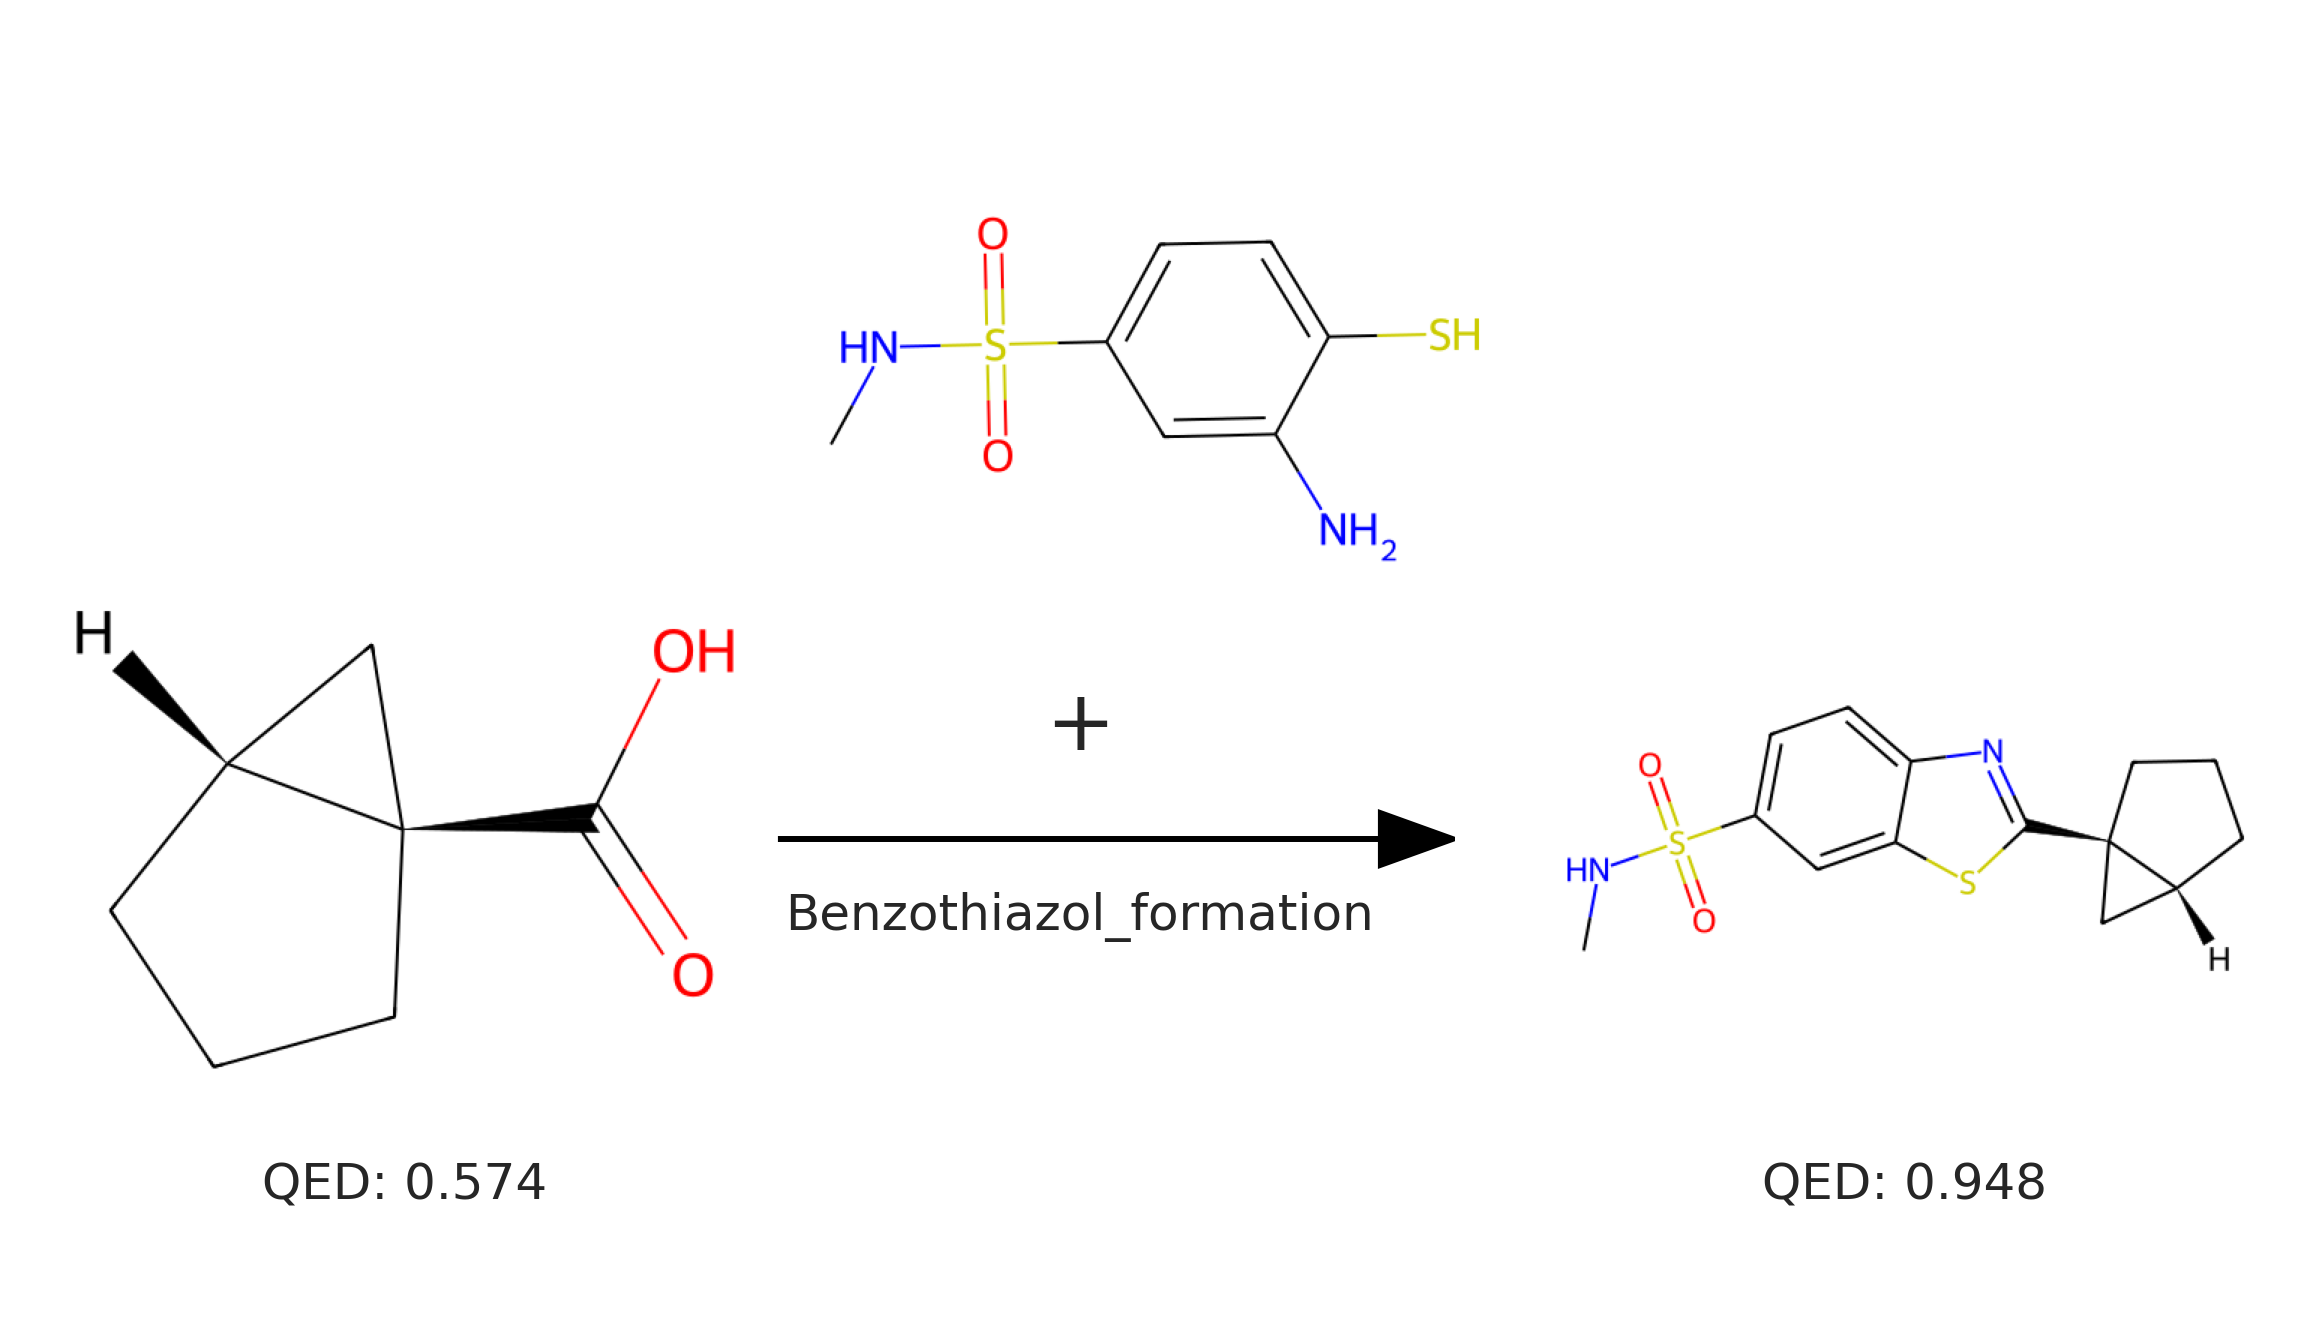

In [21]:
# synthesis path for molecule with highest qed
draw_path(molsearch_results, 10706)

In [22]:
# display path with high qed
print_path(molsearch_results, 22771)

Synthesis Path ID: 22771
Step 0:
  Reactant: CC1(C)CC1S(=O)(=O)Cl | Name: 2,2-dimethylcyclopropane-1-sulfonyl chloride
  Template: nan
  Product: CC1(C)CC1S(=O)(=O)Cl | Name: 2,2-dimethylcyclopropane-1-sulfonyl chloride
  QED Score: 0.554
----------------------------------------
Step 1:
  Reactant: CC1(C)CC1S(=O)(=O)Cl | Name: 2,2-dimethylcyclopropane-1-sulfonyl chloride
  Second Reactant: Nc1ccc(Cl)c2cccnc12 | Name: 5-chloroquinolin-8-amine
  Template: Sulfonamide_formation
  Product: CC1(C)CC1S(=O)(=O)Nc1ccc(Cl)c2cccnc12 | Name: Molecule not in PubChem Database
  QED Score: 0.945
----------------------------------------
Step 2:
  Reactant: CC1(C)CC1S(=O)(=O)Nc1ccc(Cl)c2cccnc12 | Name: Molecule not in PubChem Database
  Template: FGI_Rosenmund-von_Braun
  Product: CC1(C)CC1S(=O)(=O)Nc1ccc(C#N)c2cccnc12 | Name: Molecule not in PubChem Database
  QED Score: 0.944
----------------------------------------


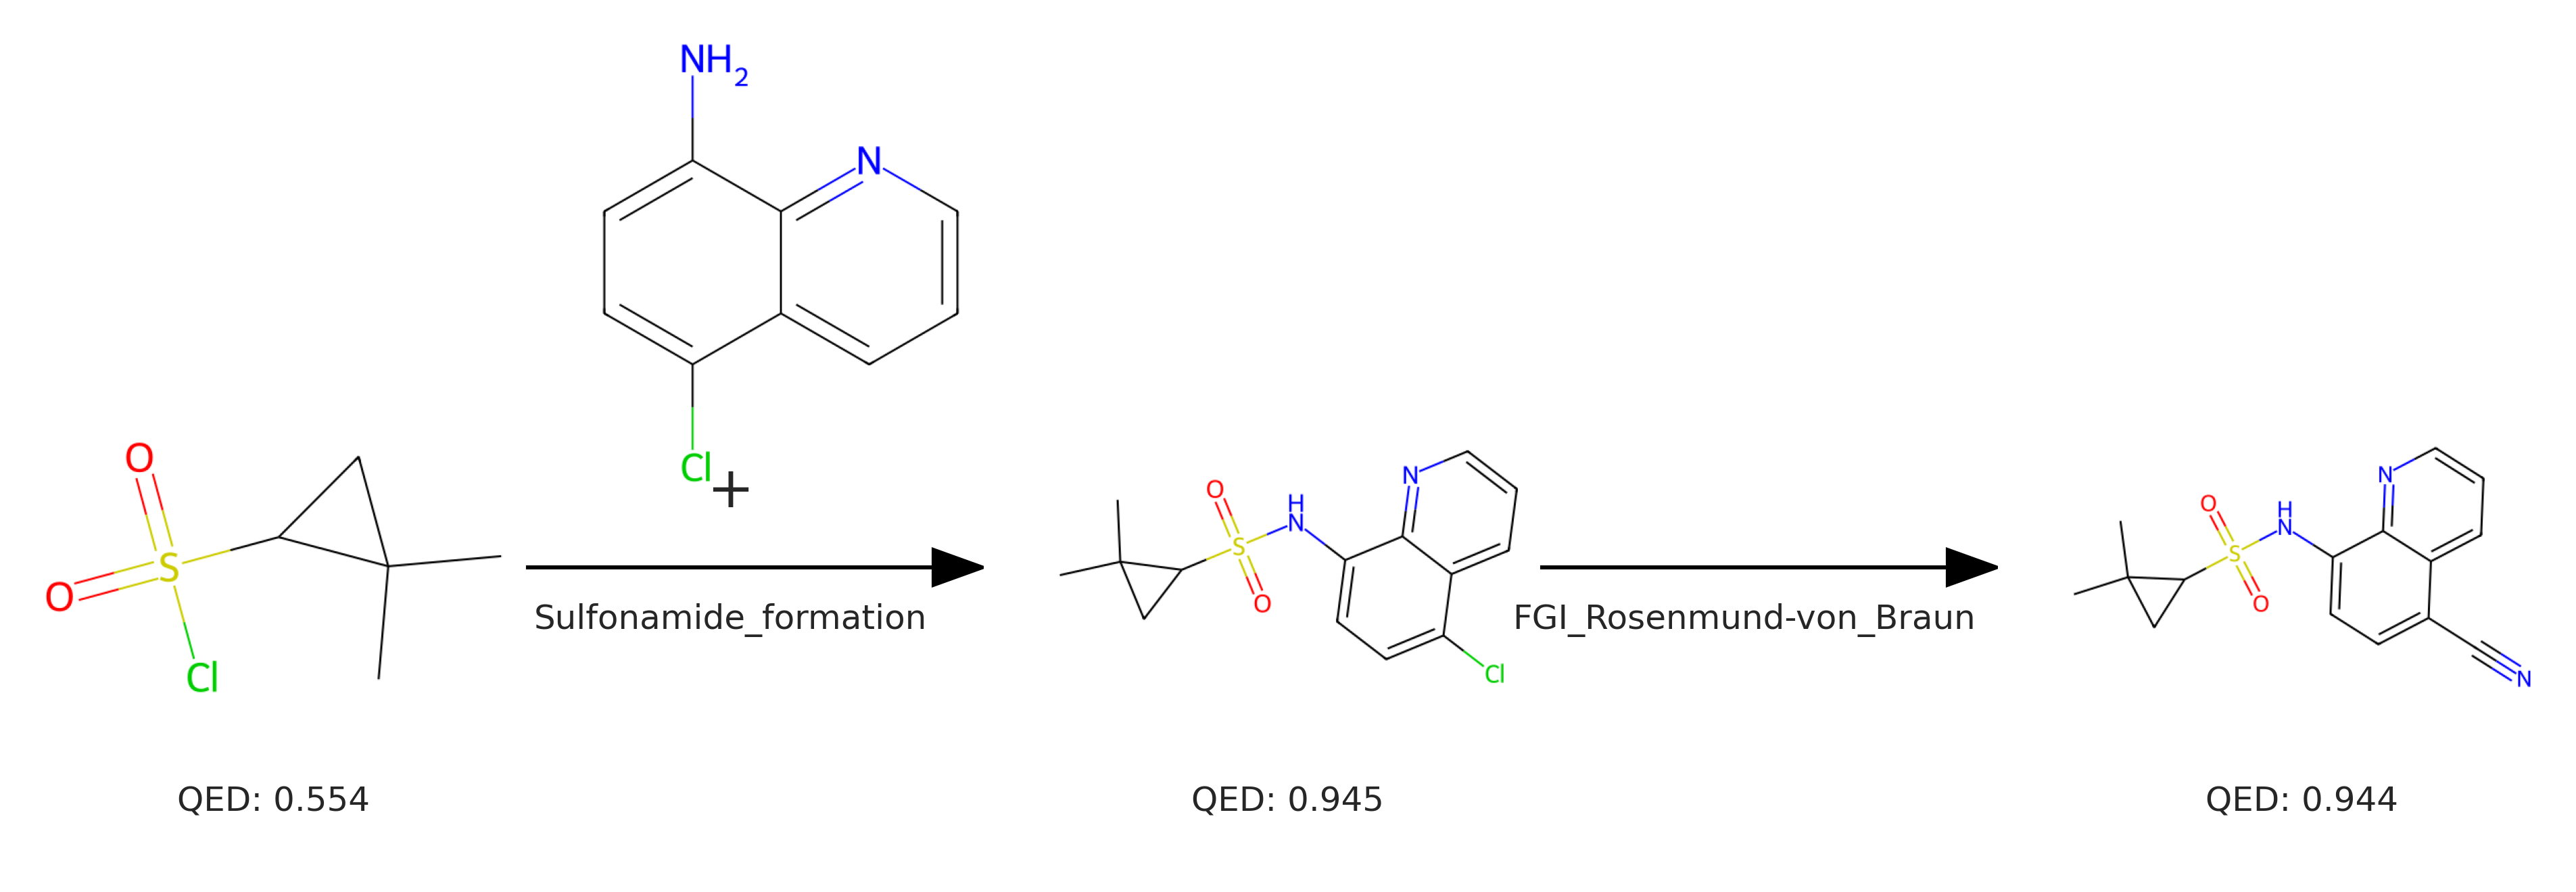

In [23]:
draw_path(molsearch_results, 22771)

In [24]:
# display path with lowest qed
print_path(molsearch_results, 13511)

Synthesis Path ID: 13511
Step 0:
  Reactant: Nc1nc(F)nc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@@H]1O | Name: [(2R,3S,4S,5R)-5-(6-amino-2-fluoropurin-9-yl)-3,4-dihydroxyoxolan-2-yl]methyl dihydrogen phosphate
  Template: nan
  Product: Nc1nc(F)nc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@@H]1O | Name: [(2R,3S,4S,5R)-5-(6-amino-2-fluoropurin-9-yl)-3,4-dihydroxyoxolan-2-yl]methyl dihydrogen phosphate
  QED Score: 0.306
----------------------------------------
Step 1:
  Reactant: Nc1nc(F)nc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@@H]1O | Name: [(2R,3S,4S,5R)-5-(6-amino-2-fluoropurin-9-yl)-3,4-dihydroxyoxolan-2-yl]methyl dihydrogen phosphate
  Template: FGI_chlorination
  Product: Nc1nc(F)nc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@@H]1Cl | Name: [(2R,3R,4S,5R)-5-(6-amino-2-fluoropurin-9-yl)-4-chloro-3-hydroxyoxolan-2-yl]methyl dihydrogen phosphate
  QED Score: 0.307
----------------------------------------
Step 2:
  Reactant: Nc1nc(F)nc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](

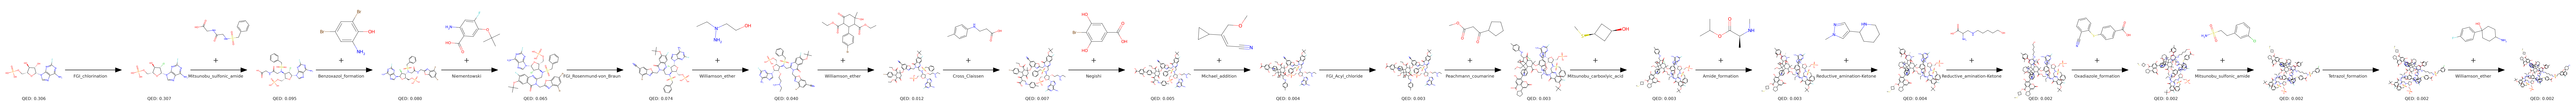

In [25]:
# Synthesis path with lowest qed
draw_path(molsearch_results, 13511)

In [36]:
# Paths that achieved the max number of steps (5)
last_steps[last_steps["step"]==5].sort_values(by='qed', ascending=False)

step                                           reactant  \
path_id path_id                                                            
3423    3423        5     CCNC(c1cc(Cl)cc(C#N)c1)c1nc2c(C#N)cc(C#N)cc2o1   
2503    2503        5     CC(C)c1c(-c2ccccc2)[nH]c2c(Br)c(C#N)cc(C#N)c12   
21731   21731       5   COc1cc(C#N)cc2c(CC(=O)O)c(-c3ccc(C#N)cc3)[nH]c12   
18070   18070       5          O=C(SCC1CCCCN1)c1c(Cl)cccc1Oc1coc2cccnc12   
12196   12196       5       N#Cc1cc(Br)cc2oc(C(Cl)(Br)C3CC4(CCC4)C3)nc12   
...               ...                                                ...   
9289    9289        5  CCn1c(S)nc(=O)c2c(C(=O)NCC(CNS(=O)(=O)C3CCOC(C...   
2387    2387        5  C=CCc1c(CC)c2c(n1C(C)C(OC(=O)CNC(=O)CN([C@H](C...   
16919   16919       5  COC(=O)c1c(N)n(-c2ccc(Oc3ccc(Oc4ccc(-c5sc(C(=O...   
2022    2022        5  CNS(=O)(=O)c1ccc2nc(C(N)(Br)CNCCCCCOc3cc(NC(=S...   
20341   20341       5  CCC[CH][C@@H](N)C(=O)C1(CCCOc2cc(Oc3ccc4[nH]cc...   

                                template  \
path_id path_id                            
3423    3423     FGI_Rosenmund-von_Braun   
2503    2503     FGI_Rosenmund-von_Braun   
21731   21731          FGI_Acyl_chloride   
18070   18070    FGI_Rosenmund-von_Braun   
12196   12196    FGI_Rosenmund-von_Braun   
...                                  ...   
9289    9289            Williamson_ether   
2387    2387                        Heck   
16919   16919            Amide_formation   
2022    2022                     Negishi   
20341   20341            Ester_formation   

                                                           product    qed  \
path_id path_id                                                             
3423    3423       CCNC(c1cc(C#N)cc(C#N)c1)c1nc2c(C#N)cc(C#N)cc2o1  0.762   
2503    2503       CC(C)c1c(-c2ccccc2)[nH]c2c(C#N)c(C#N)cc(C#N)c12  0.751   
21731   21731    COc1cc(C#N)cc2c(CC(=O)Cl)c(-c3ccc(C#N)cc3)[nH]c12  0.723   
18070   18070           N#Cc1cccc(Oc2coc3cccnc23)c1C(=O)SCC1CCCCN1  0.682   
12196   12196        N#Cc1cc(C#N)c2nc(C(Cl)(Br)C3CC4(CCC4)C3)oc2c1  0.681   
...                                                            ...    ...   
9289    9289     CCCc1cc(=O)oc2c(C)c(O[C@H](C)c3ccc(Oc4ccc(CC(C...  0.011   
2387    2387     C=C(Cc1cccc(N=[N+]=[N-])c1)Cc1c(CC)c2c(n1C(C)C...  0.010   
16919   16919    COC(=O)c1c(N)n(-c2ccc(Oc3ccc(Oc4ccc(-c5sc(C(=O...  0.010   
2022    2022     CNS(=O)(=O)c1ccc2nc(C(N)(Br)CNCCCCCOc3cc(NC(=S...  0.009   
20341   20341    CCC[CH][C@@H](N)C(=O)C1(CCCOc2cc(Oc3ccc4[nH]cc...  0.007   

                                            second_reactant  
path_id path_id                                              
3423    3423                                            NaN  
2503    2503                                            NaN  
21731   21731                                           NaN  
18070   18070                                           NaN  
12196   12196                                           NaN  
...                                                     ...  
9289    9289     CCCc1cc(=O)oc2c(C)c(O)c(C(=O)C=CN(C)C)cc12  
2387    2387                       [N-]=[N+]=Nc1cccc(CBr)c1  
16919   16919                              NC1(C(F)(F)F)CC1  
2022    2022                           Clc1ccc(CCCCBr)cc1Cl  
20341   20341              CC(C)(C)OC(=O)N1CCCC1c1ccc(O)cc1  

[1124 rows x 6 columns]

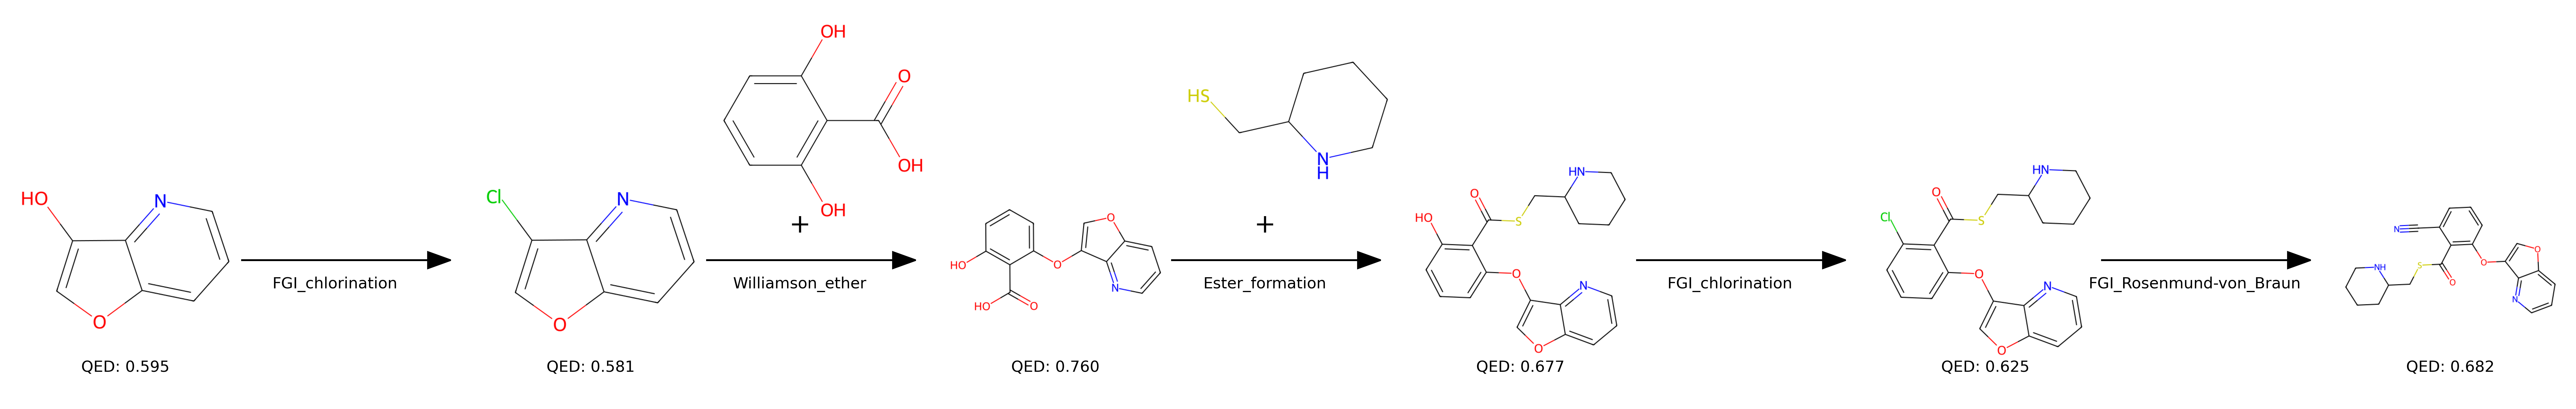

In [15]:
draw_path(molsearch_results, 18070)

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(molsearch_results['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores', fontsize=16)
plt.xlabel('QED Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()


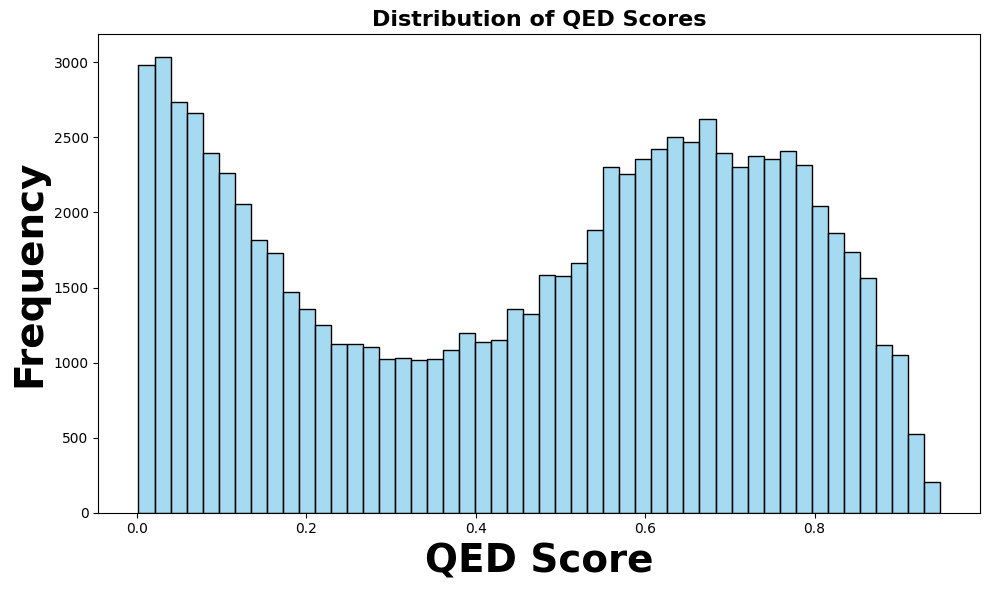

In [13]:
# Distribution of QED scores
plt.figure(figsize=(10, 6))
sns.histplot(molsearch_results['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores', fontsize=16, fontweight='bold')
plt.xlabel('QED Score', fontsize=28, fontweight='bold')
plt.ylabel('Frequency', fontsize=28, fontweight='bold')
plt.tight_layout()
plt.show()

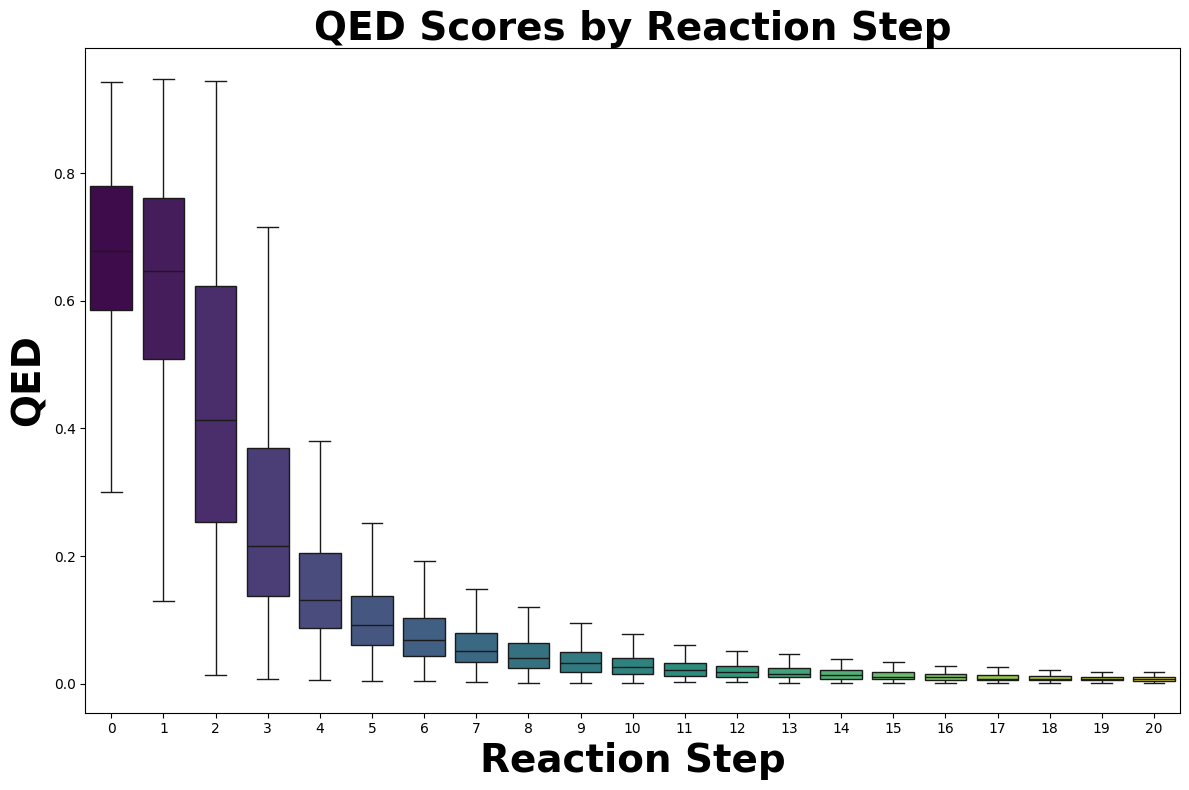

In [14]:
# Box plot for QED scores by reaction step with customized settings to avoid FutureWarning
plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='qed', data=molsearch_results, hue='step', palette="viridis", showfliers=False, dodge=False)
plt.legend([], [], frameon=False)  # Remove legend
plt.title('QED Scores by Reaction Step', fontsize=28, fontweight='bold')
plt.xlabel('Reaction Step', fontsize=28, fontweight='bold')
plt.ylabel('QED', fontsize=28, fontweight='bold')
plt.tight_layout()
plt.show()

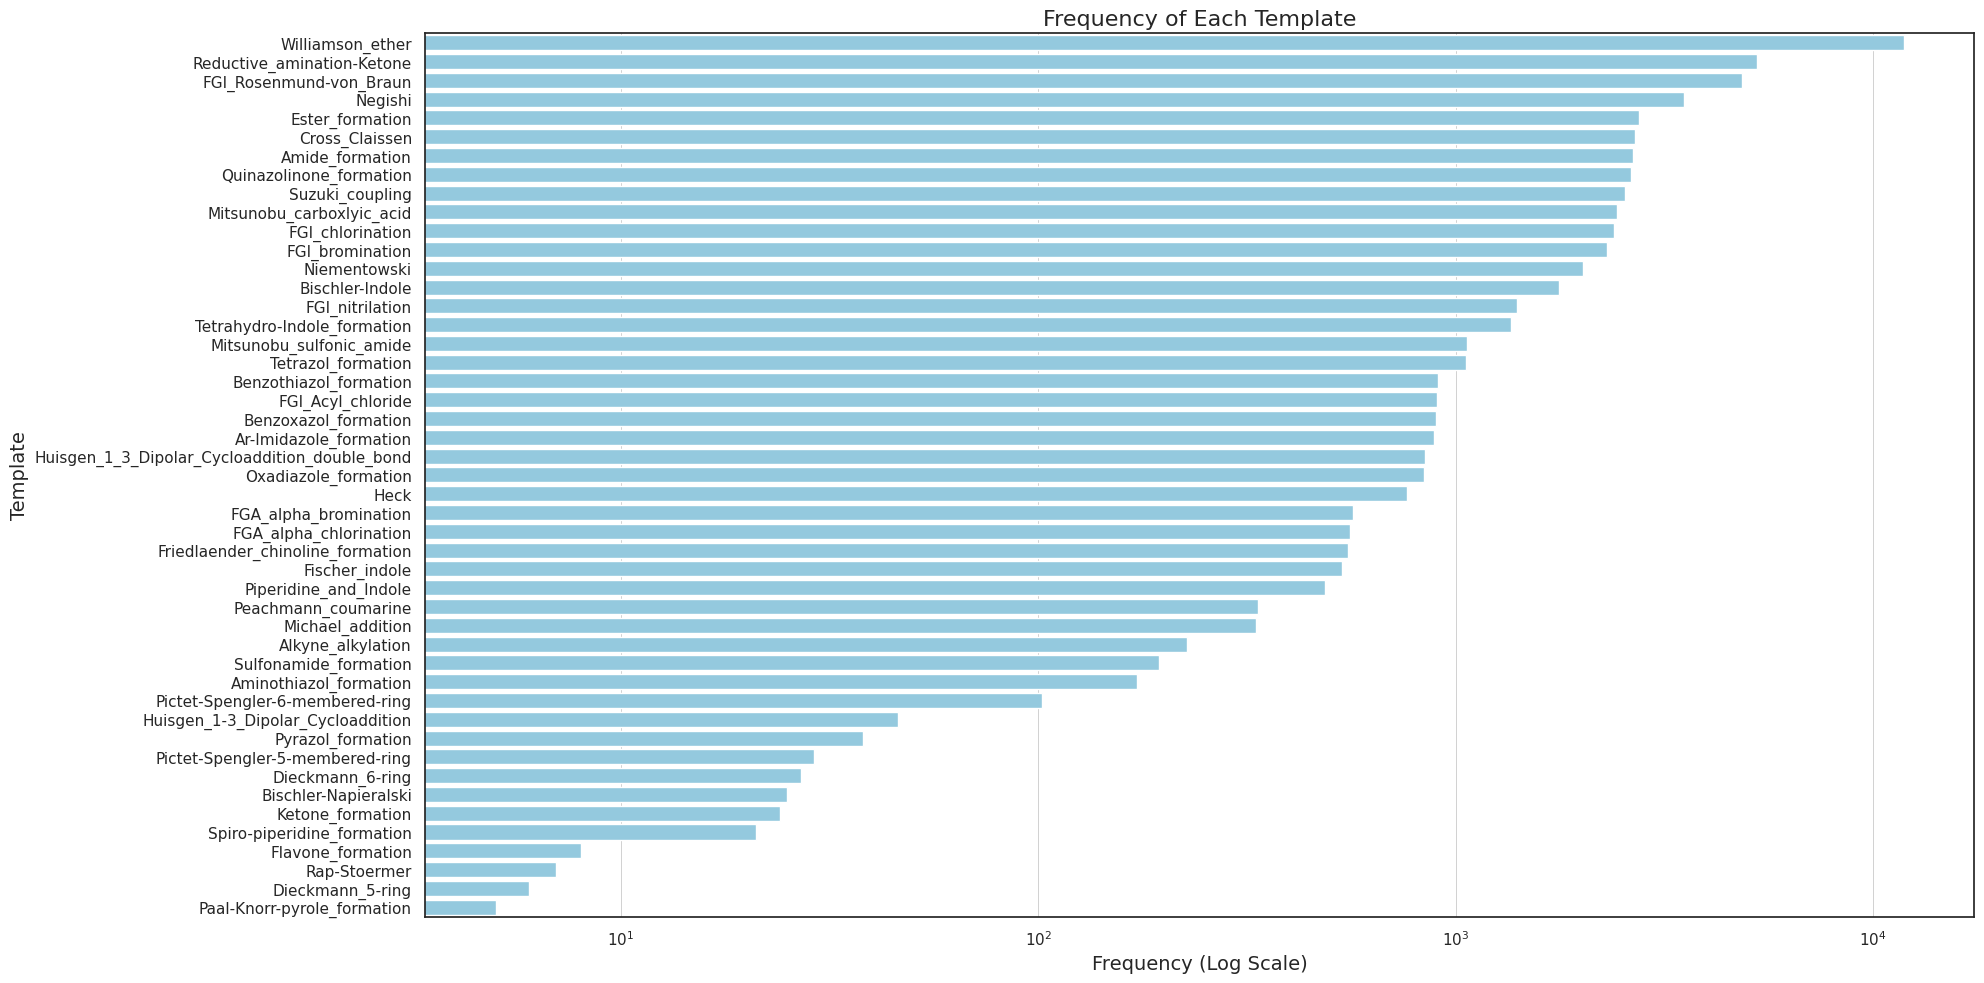

In [32]:
# Calculate frequency of each template
template_frequency = molsearch_results['template'].value_counts().reset_index()
template_frequency.columns = ['template', 'frequency']

# Create horizontal bar plot with log scale for frequency
plt.figure(figsize=(20, 10))
sns.barplot(y='template', x='frequency', data=template_frequency, color='skyblue')
plt.xscale('log')
plt.title('Frequency of Each Template', fontsize=16)
plt.xlabel('Frequency (Log Scale)', fontsize=14)
plt.ylabel('Template', fontsize=14)
# Add faint grey grid lines
plt.grid(color='grey', linestyle='-', linewidth=0.5, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

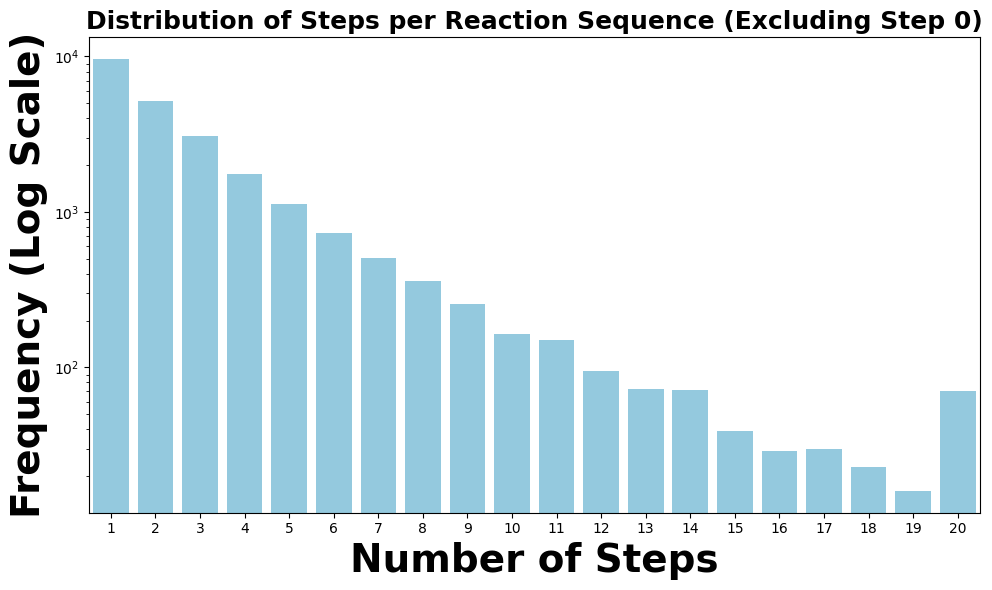

In [17]:
# Filter out step 0
df_filtered = molsearch_results[molsearch_results['step'] != 0]

# Calculate the number of steps per reaction sequence
steps_per_sequence = df_filtered.groupby('path_id')['step'].max()

# Calculate the frequency of each number of steps
steps_frequency = steps_per_sequence.value_counts().sort_index()

# Create a bar chart with log scale for frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=steps_frequency.index, y=steps_frequency.values, color='skyblue')
plt.yscale('log')
plt.title('Distribution of Steps per Reaction Sequence (Excluding Step 0)', fontsize=18, fontweight='bold')
plt.xlabel('Number of Steps', fontsize=28, fontweight='bold')
plt.ylabel('Frequency (Log Scale)', fontsize=28, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1477557/1962642310.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["reactant"] = data['reactant'].apply(get_compound_name)


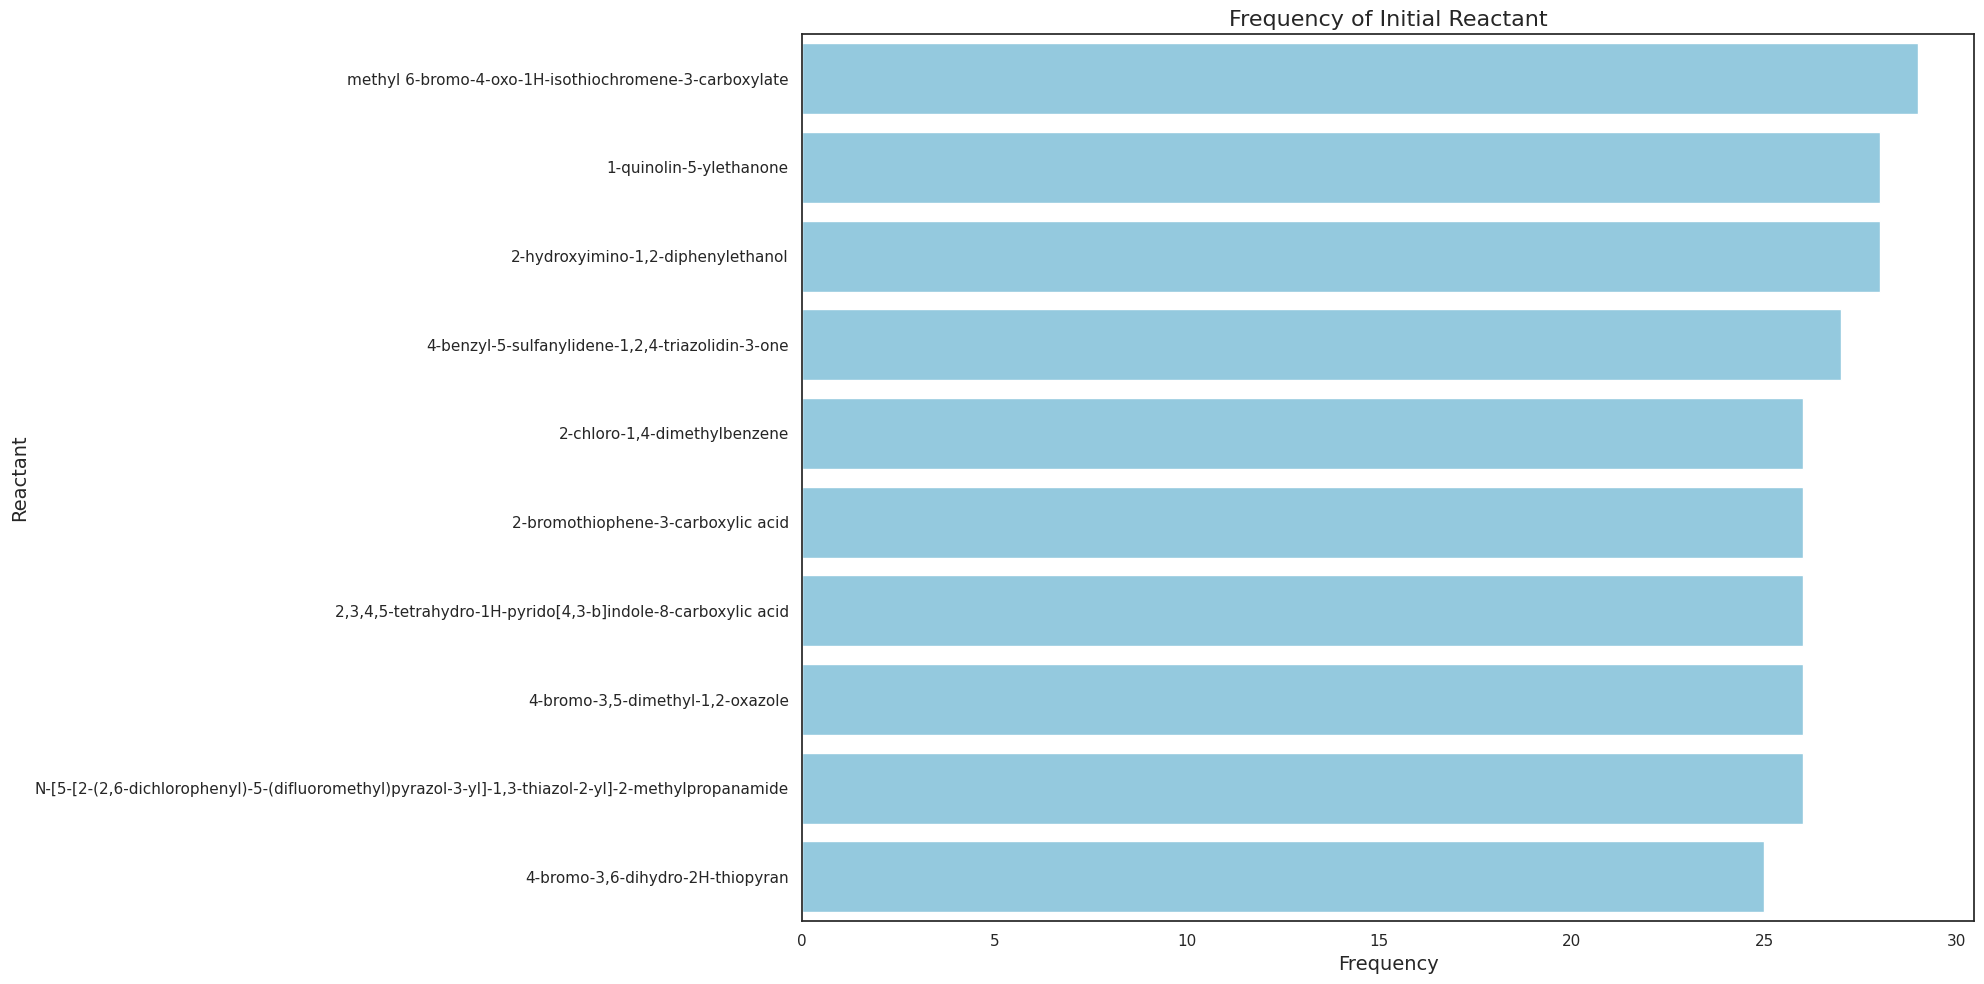

In [29]:
# Filter the DataFrame for step 0
df_step_0 = molsearch_results[molsearch_results['step'] == 0]

# Calculate the frequency of each combined reactant
reactant_frequency_step_0 = df_step_0['reactant'].value_counts().reset_index()
reactant_frequency_step_0.columns = ['reactant', 'frequency']
data = reactant_frequency_step_0.head(10)
data["reactant"] = data['reactant'].apply(get_compound_name)

# Create a horizontal bar chart
plt.figure(figsize=(20, 10))
sns.barplot(y='reactant', x='frequency', data=data, color='skyblue')
#plt.xscale('log')
plt.title('Frequency of Initial Reactant', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Reactant', fontsize=14)
plt.tight_layout()
plt.show()